In [1]:
import numpy as np
import scipy.optimize
import pandas as pd
import matplotlib.pyplot as plt
from random import randint, seed
import seaborn as sns
import scipy
from tqdm import tqdm
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import pandas as pd
import keras
import scipy
import requests
import glob
import os

exps with real proteins and G4

In [2]:
!rm -r /content/sample_data

### Downloading & sampling real proteins from SwissProt

In [7]:
!wget https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/complete/uniprot_sprot.fasta.gz

--2023-05-24 19:13:58--  https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/complete/uniprot_sprot.fasta.gz
Resolving ftp.uniprot.org (ftp.uniprot.org)... 128.175.240.195
Connecting to ftp.uniprot.org (ftp.uniprot.org)|128.175.240.195|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 91646105 (87M) [application/x-gzip]
Saving to: ‘uniprot_sprot.fasta.gz’

uniprot_sprot.fasta 100%[===================>]  87.40M   357KB/s    in 4m 27s  

2023-05-24 19:18:25 (336 KB/s) - ‘uniprot_sprot.fasta.gz’ saved [91646105/91646105]



In [9]:
!gunzip uniprot_sprot.fasta.gz

In [15]:
!mkdir /content/drive/MyDrive/thesis

In [16]:
!mv /content/uniprot_sprot.fasta /content/drive/MyDrive/thesis/

In [3]:
!head /content/drive/MyDrive/thesis/uniprot_sprot.fasta

>sp|Q6GZX4|001R_FRG3G Putative transcription factor 001R OS=Frog virus 3 (isolate Goorha) OX=654924 GN=FV3-001R PE=4 SV=1
MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQVECPKAPVEWNNPPS
EKGLIVGHFSGIKYKGEKAQASEVDVNKMCCWVSKFKDAMRRYQGIQTCKIPGKVLSDLD
AKIKAYNLTVEGVEGFVRYSRVTKQHVAAFLKELRHSKQYENVNLIHYILTDKRVDIQHL
EKDLVKDFKALVESAHRMRQGHMINVKYILYQLLKKHGHGPDGPDILTVKTGSKGVLYDD
SFRKIYTDLGWKFTPL
>sp|Q6GZX3|002L_FRG3G Uncharacterized protein 002L OS=Frog virus 3 (isolate Goorha) OX=654924 GN=FV3-002L PE=4 SV=1
MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQTCASGFCTSQPLCAR
IKKTQVCGLRYSSKGKDPLVSAEWDSRGAPYVRCTYDADLIDTQAQVDQFVSMFGESPSL
AERYCMRGVKNTAGELVSRVSSDADPAGGWCRKWYSAHRGPDQDAALGSFCIKNPGAADC


In [22]:
! grep '>' /content/drive/MyDrive/thesis/uniprot_sprot.fasta >> allprotnames.txt

In [23]:
!head allprotnames.txt

>sp|Q6GZX4|001R_FRG3G Putative transcription factor 001R OS=Frog virus 3 (isolate Goorha) OX=654924 GN=FV3-001R PE=4 SV=1
>sp|Q6GZX3|002L_FRG3G Uncharacterized protein 002L OS=Frog virus 3 (isolate Goorha) OX=654924 GN=FV3-002L PE=4 SV=1
>sp|Q197F8|002R_IIV3 Uncharacterized protein 002R OS=Invertebrate iridescent virus 3 OX=345201 GN=IIV3-002R PE=4 SV=1
>sp|Q197F7|003L_IIV3 Uncharacterized protein 003L OS=Invertebrate iridescent virus 3 OX=345201 GN=IIV3-003L PE=4 SV=1
>sp|Q6GZX2|003R_FRG3G Uncharacterized protein 3R OS=Frog virus 3 (isolate Goorha) OX=654924 GN=FV3-003R PE=3 SV=1
>sp|Q6GZX1|004R_FRG3G Uncharacterized protein 004R OS=Frog virus 3 (isolate Goorha) OX=654924 GN=FV3-004R PE=4 SV=1
>sp|Q197F5|005L_IIV3 Uncharacterized protein 005L OS=Invertebrate iridescent virus 3 OX=345201 GN=IIV3-005L PE=3 SV=1
>sp|Q6GZX0|005R_FRG3G Uncharacterized protein 005R OS=Frog virus 3 (isolate Goorha) OX=654924 GN=FV3-005R PE=4 SV=1
>sp|Q91G88|006L_IIV6 Putative KilA-N domain-containing protein

In [24]:
">sp|Q6GZX4|001R_FRG3G Putative transcription factor".split('|')

['>sp', 'Q6GZX4', '001R_FRG3G Putative transcription factor']

In [25]:
uniprot_ids = []
with open("allprotnames.txt") as f:
    for line in f:
        uniprot_ids.append(line.split('|')[1])
        with open("uniprot_ids.txt", "w") as my_file:
          my_file.write(line.split('|')[1] + "\n")


In [28]:
uniprot_ids[np.random.randint(5, size=1)[0]]

'Q197F7'

In [36]:
!rm sampled_uniprot_ids.txt
!rm sampled_uniprot_seqs.txt

In [37]:
n = len(uniprot_ids) #569516
num_samples = 107 + 77
with open("sampled_uniprot_ids.txt", "w") as f:
  with open("sampled_uniprot_seqs.txt", "w") as s:
    for _ in range(num_samples):
      id = uniprot_ids[np.random.randint(n, size=1)[0]]
      f.write(id + '\n')
      
      url = "https://rest.uniprot.org/uniprotkb/" + id + ".fasta"
      r = requests.get(url)
      s.write("".join(str(r.content).split("\\n")[1:-1])+ '\n')

In [40]:
!head sampled_uniprot_seqs.txt

MKRAFIMVLDSFGIGATEDADRFGDVGSDTLGHIAEACAKGEADNGRKGPLNLPNLTRLGLVKAHEGSTGKIAAGMDGNADVIGAYAWAHELSSGKDTPSGHWEIAGVPVLFDWGYFSDHENSFPQELLDKLVKRANLPGYLGNCHSSGTVILDQLGEEHMKTGKPIFYTSADSVFQIACHEETFGLDKLYELCEIAREELTVGGYNIGRVIARPFIGDKAGNFQRTGNRHDLAVEPPAPTVLQKLVDEKQGHVVSVGKIADIYANCGITKKVKATGLDALFDATLKEMKEAGDKTIVFTNFVDFDSSWGHRRDIAGYAAGLELFDRRLPELMELVGEDDILILTADHGCDPSWTGTDHTREHIPVLIYGPKVKPGSLGHRETFADIGQTLATYFGTSPMDYGKNML
MEEIRFCPEHGFYRGEKCRCGAEGELILPKEKVEKLGKFISGVLRHFPDKFGLNMDENGWVNLESLARVVKRRYKWANIWLIKALVYSDEKQRYELKGDKIRARYGHSIDVKLSDFPEAKEDVLYYGTSEEEAHRMLEIGIKPVNQRYVHLSTTIEKSKEVASIRTDTPIVLEIDAKKAREDGIRIIKANDLIALAEEIPAKYIKRQIVFNQYSSS
MQGGKKAGESIKETATNIGASAKAGMEKTKATVQEKAERMTARDPVQKELATQKKEAKMNQAELDKQAARQHNTAAKQSATTAGHMGHGHHTTGTGTGTATYSTTGEYGQPMGAHQTSAMPGHGTGQPTGHVTEGVVGSHPIGTNRGPGGTATAHNTRAGGKPNDYGYGTGGT
MSDPMKTALSLVPMVIEQTNRGERAYDIFSRLLKERIIFINGPVEDGMAMLVCAQLLFLEAENPKKEISLYINSPGGVVTSGMAIYDTMQFIRPPVSTLCMGQAASMGSLLLTAGAKGHRFALPNARIMVHQPSGGFQGQASDIERHAQDIIKMKRRLNEIYVQHTGQGYEVIERTLDRDHFMTAEEAKAFGLVDDVIHYR

In [41]:
!mv /content/sampled_uniprot_seqs.txt /content/drive/MyDrive/thesis/
!mv /content/sampled_uniprot_ids.txt /content/drive/MyDrive/thesis/

### Embeding

In [9]:
#edited /content/PDBP-Fusion/predict.py

from keras.models import load_model
import numpy as np
from datetime import datetime
import tensorflow as tf
import numpy as np
import pdb

def get_nuq_concolutional_array(seq, str_len=201, RNA=False):
    alpha = 'ACGT'
    if RNA:
      alpha = 'ACGU'
    row = (len(seq))
    new_array = np.zeros((row, 4))

    for i, val in enumerate(seq):

        if val not in alpha:
            if val == 'Z':
                new_array[i] = np.array([0.0] * 4)
            # if val == 'S':
            #     new_array[i] = np.array([0, 0.5, 0.5, 0, 0])
            continue

        try:
            index = alpha.index(val)
            new_array[i][index] = 1
        except ValueError:
            pdb.set_trace()
    return new_array  

def get_seq_concolutional_array(seq): #from encode_schema.py
    # seq = seq.replace('U', 'T')
    alpha = 'ACDEFGHIKLMNPQRSTVWY'
    row = (len(seq))
    new_array = np.zeros((row, 20))

    for i, val in enumerate(seq):

        if val not in 'ACDEFGHIKLMNPQRSTVWY':
            if val == 'Z':
                new_array[i] = np.array([0.0] * 20)
            # if val == 'S':
            #     new_array[i] = np.array([0, 0.5, 0.5, 0, 0])
            continue

        try:
            index = alpha.index(val)
            new_array[i][index] = 1
        except ValueError:
            pdb.set_trace()
    return new_array

def read_seq_onehot(seq_file, str_len=600): #from encode_schema.py fix const 600 (was 850)
    seq_list = []
    seq = ''
    with open(seq_file, 'r') as fp:
        index = 0
        for line in fp:
            index += 1
            string = line
            if len(line)>=str_len:
                string=string[:str_len]
            else:
                string=string+'Z'*(str_len-len(string))
            
            assert len(string)==str_len
            line = string

            seq = line
            seq_array = get_seq_concolutional_array(seq)
            seq_list.append(seq_array)
        print(index)
    return np.array(seq_list, dtype=object)

def read_nuq_onehot(seq_file, str_len=201, RNA=False): 
    seq_list = []
    seq = ''
    with open(seq_file, 'r') as fp:
        index = 0
        for line in fp:
            index += 1
            string = line
            if len(line)>=str_len:
                string=string[:str_len]
            else:
                string=string+'Z'*(str_len-len(string))
            
            assert len(string)==str_len
            line = string

            seq = line
            seq_array = get_nuq_concolutional_array(seq,str_len=201, RNA=RNA)
            seq_list.append(seq_array)
        print(index)
    return np.array(seq_list, dtype=object)


class Pred():
    def __init__(self,model_path='./model_save/model_'):
        self.item_model_path = ''
        #self.model = load_model(item_model_path)

    def sample_predict1(self,string,str_len=600):
        # make sure the input sequnce less than 850, otherwise drop string when length excell 850
        if len(string)>=str_len:
            string=string[:str_len]
        else:
            string=string+'Z'*(str_len-len(string))
        #print('len: ',str_len)
        assert len(string)==str_len

        #向量化
        #print(get_seq_concolutional_array(string)[:5,:])
        string_vector=get_seq_concolutional_array(string)
        string_vector=np.expand_dims(string_vector,0)

        #load model and predict
        result=[]
        self.model = load_model(self.item_model_path)
        predict=self.model.predict(string_vector)[0]
        print('prediction is {}'.format(predict))
        result.append(predict)
        print(result)

        return result

    def sample_predict(self,string,str_len=600):
        # make sure the input sequnce less than 850, otherwise drop string when length excell 850

        seq = read_seq_onehot(string)
        print(seq.shape)
        # seq = np.asarray(seq).astype(np.float32)
        # string_vector=get_seq_concolutional_array(string)
        # string_vector=np.expand_dims(string_vector,0)

        #load model and predict
        result=[]
        self.model = load_model(self.item_model_path)
        predict=self.model.predict(tf.convert_to_tensor(seq, dtype=tf.float32))
        print('prediction is {}'.format(predict))
        result.append(predict)

        return result

    def get_emb_prot(self, path, str_len=600):
        seq = read_seq_onehot(path, str_len)
        config = '{"class_name": "Model", "config": {"name": "DBP_CNN_model", "layers": [{"name": "input", "class_name": "InputLayer", "config": {"batch_input_shape": [null, 600, 20], "dtype": "float32", "sparse": false, "name": "input"}, "inbound_nodes": []}, {"name": "conv1d_10", "class_name": "Conv1D", "config": {"name": "conv1d_10", "trainable": true, "dtype": "float32", "filters": 64, "kernel_size": [9], "strides": [1], "padding": "same", "data_format": "channels_last", "dilation_rate": [1], "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "RandomUniform", "config": {"minval": -0.05, "maxval": 0.05, "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}, "inbound_nodes": [[["input", 0, 0, {}]]]}, {"name": "max_pooling1d_10", "class_name": "MaxPooling1D", "config": {"name": "max_pooling1d_10", "trainable": true, "dtype": "float32", "strides": [2], "pool_size": [2], "padding": "valid", "data_format": "channels_last"}, "inbound_nodes": [[["conv1d_10", 0, 0, {}]]]}, {"name": "dropout_10", "class_name": "Dropout", "config": {"name": "dropout_10", "trainable": true, "dtype": "float32", "rate": 0.3, "noise_shape": null, "seed": null}, "inbound_nodes": [[["max_pooling1d_10", 0, 0, {}]]]}, {"name": "conv1d_11", "class_name": "Conv1D", "config": {"name": "conv1d_11", "trainable": true, "dtype": "float32", "filters": 64, "kernel_size": [9], "strides": [1], "padding": "same", "data_format": "channels_last", "dilation_rate": [1], "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "RandomUniform", "config": {"minval": -0.05, "maxval": 0.05, "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}, "inbound_nodes": [[["dropout_10", 0, 0, {}]]]}, {"name": "max_pooling1d_11", "class_name": "MaxPooling1D", "config": {"name": "max_pooling1d_11", "trainable": true, "dtype": "float32", "strides": [2], "pool_size": [2], "padding": "valid", "data_format": "channels_last"}, "inbound_nodes": [[["conv1d_11", 0, 0, {}]]]}, {"name": "dropout_11", "class_name": "Dropout", "config": {"name": "dropout_11", "trainable": true, "dtype": "float32", "rate": 0.3, "noise_shape": null, "seed": null}, "inbound_nodes": [[["max_pooling1d_11", 0, 0, {}]]]}, {"name": "bidirectional_6", "class_name": "Bidirectional", "config": {"name": "bidirectional_6", "trainable": true, "dtype": "float32", "layer": {"class_name": "LSTM", "config": {"name": "lstm_5", "trainable": true, "dtype": "float32", "return_sequences": true, "return_state": false, "go_backwards": false, "stateful": false, "unroll": false, "units": 16, "activation": "tanh", "recurrent_activation": "sigmoid", "use_bias": true, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"scale": 1.0, "mode": "fan_avg", "distribution": "uniform", "seed": null}}, "recurrent_initializer": {"class_name": "Orthogonal", "config": {"gain": 1.0, "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "unit_forget_bias": true, "kernel_regularizer": null, "recurrent_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "recurrent_constraint": null, "bias_constraint": null, "dropout": 0.0, "recurrent_dropout": 0.0, "implementation": 2}}, "merge_mode": "concat"}, "inbound_nodes": [[["dropout_11", 0, 0, {}]]]}, {"name": "dropout_25", "class_name": "Dropout", "config": {"name": "dropout_25", "trainable": true, "dtype": "float32", "rate": 0.3, "noise_shape": null, "seed": null}, "inbound_nodes": [[["bidirectional_6", 0, 0, {}]]]}, {"name": "flatten_6", "class_name": "Flatten", "config": {"name": "flatten_6", "trainable": true, "dtype": "float32", "data_format": "channels_last"}, "inbound_nodes": [[["dropout_25", 0, 0, {}]]]}, {"name": "dense_11", "class_name": "Dense", "config": {"name": "dense_11", "trainable": true, "dtype": "float32", "units": 128, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"scale": 1.0, "mode": "fan_avg", "distribution": "uniform", "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}, "inbound_nodes": [[["flatten_6", 0, 0, {}]]]}, {"name": "batch_normalization_5", "class_name": "BatchNormalization", "config": {"name": "batch_normalization_5", "trainable": true, "dtype": "float32", "axis": -1, "momentum": 0.99, "epsilon": 0.001, "center": true, "scale": true, "beta_initializer": {"class_name": "Zeros", "config": {}}, "gamma_initializer": {"class_name": "Ones", "config": {}}, "moving_mean_initializer": {"class_name": "Zeros", "config": {}}, "moving_variance_initializer": {"class_name": "Ones", "config": {}}, "beta_regularizer": null, "gamma_regularizer": null, "beta_constraint": null, "gamma_constraint": null}, "inbound_nodes": [[["dense_11", 0, 0, {}]]]}, {"name": "dropout_3", "class_name": "Dropout", "config": {"name": "dropout_3", "trainable": true, "dtype": "float32", "rate": 0.3, "noise_shape": null, "seed": null}, "inbound_nodes": [[["batch_normalization_5", 0, 0, {}]]]}, {"name": "dense_12", "class_name": "Dense", "config": {"name": "dense_12", "trainable": true, "dtype": "float32", "units": 2, "activation": "sigmoid", "use_bias": true, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"scale": 1.0, "mode": "fan_avg", "distribution": "uniform", "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}, "inbound_nodes": [[["dropout_3", 0, 0, {}]]]}], "input_layers": [["input", 0, 0]], "output_layers": [["dense_12", 0, 0]]}, "keras_version": "2.3.1", "backend": "tensorflow"}'
 
        model = keras.models.model_from_json(config)

        self.model = tf.keras.Model(inputs=model.input, outputs=model.layers[-3].output,
                                    name='model_EmbPr')
        predict = self.model.predict(tf.convert_to_tensor(seq, dtype=tf.float32))
        return predict

    def get_emb_dna(self, path, str_len=201):
        seq = read_nuq_onehot(path, str_len=201)
        print(seq.shape)
        result = []
        deepg4 = keras.models.load_model('/content/drive/MyDrive/thesis/best_model.h5')
        self.model = tf.keras.Model(inputs=deepg4.input, outputs=deepg4.layers[-3].output,
                         name='model_EmbG4')
        predict = self.model.predict(tf.convert_to_tensor(seq, dtype=tf.float32))
        return predict

    def get_emb_rna(self, path, str_len=201):
        seq = read_nuq_onehot(path, str_len=201, RNA=True)
        print(seq.shape)
        result = []
        deepg4 = keras.models.load_model('/content/drive/MyDrive/thesis/best_model.h5')

        self.model = tf.keras.Model(inputs=deepg4.input, outputs=deepg4.layers[-3].output,
                         name='model_EmbG4')
        predict = self.model.predict(tf.convert_to_tensor(seq, dtype=tf.float32))
        return predict


### Prot Emb

In [5]:
Pr = Pred()
real_emb_prot = Pr.get_emb_prot('/content/drive/MyDrive/thesis/sampled_uniprot_seqs.txt')

184
6/6 [==============================] - 2s 56ms/step


In [27]:
real_emb_prot.shape

(184, 128)

### G4 downloading & samling

https://www.g4ldb.com/#/result?p=g&_t=1685012405354 вручную скачивала 600 последовательностей которые не взаимодействуют с белками. Конкатенирую, нахожу уникальные, сэмплирую.

In [6]:
path = '/content/drive/MyDrive/thesis/g4_csv'
all_files = glob.glob(os.path.join(path, "*.csv"))

df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

In [16]:
df['sequence'].unique()

62

In [19]:
G4s = np.random.choice(df['sequence'].unique(), 184)

In [20]:
with open('/content/drive/MyDrive/thesis/samled_g4ldb.txt', 'w') as f:
  for g4 in G4s:
    g4 = g4.replace('\n', '')
    f.write(g4 + '\n')

In [7]:
!head /content/drive/MyDrive/thesis/samled_g4ldb.txt

AGGGAGGGCGTGGGAGGAGGG
AGGCGGGGGGGGGGGGGCGGGGGCGGGGGCGG
AGGGGAGAAAAGGAAAGGGGAGGGGAGGGA
AGGGGCGGGCGCGGGAGGAAGGGGGCGGGA
AAGGGGAGGGGCTGGGAGGGCCCGGA
AGGGTTAGGGTTAGGGTTAGGG
AGGGGGCTGGGCCGGAAACCCGGGAGGGGTCGGGACGGGGCGGGGT
AGGGGGTGGGAGGGGGCAGGGGGT
AGGGAGGGCGCTGGGAGGAGGAGGG
AGGCGGGGGGGGGGGGGCGGGGGCGGGGGCGG


In [10]:
Pr = Pred()
real_emb_g4 = Pr.get_emb_dna('/content/drive/MyDrive/thesis/samled_g4ldb.txt')

184
(184, 201, 4)
6/6 [==============================] - 0s 14ms/step


### DeepG4P

In [11]:
Pr=Pred()
dna_g4_emb = Pr.get_emb_dna('/content/drive/MyDrive/thesis/Target_DNA_Sequence.txt') #this is our embedings for DNA Target Seq
Pr=Pred()
rna_g4_emb = Pr.get_emb_rna('/content/drive/MyDrive/thesis/Target_RNA_Sequence.txt') #this is our embedings for DNA Target Seq
Pr = Pred()
prot_emb_r = Pr.get_emb_prot('/content/drive/MyDrive/thesis/prots_rna.txt')
prot_emb_d = Pr.get_emb_prot('/content/drive/MyDrive/thesis/prots_dna.txt')


107
(107, 201, 4)
4/4 [==============================] - 0s 18ms/step
60
(60, 201, 4)
2/2 [==============================] - 0s 28ms/step
60
2/2 [==============================] - 1s 43ms/step
107


4/4 [==============================] - 1s 39ms/step


In [12]:
g4 = tf.concat([dna_g4_emb, rna_g4_emb], axis=0)
prots = tf.concat([prot_emb_d, prot_emb_r], axis=0)
input = tf.concat([g4, prots], axis=-1)
labels = np.ones(input.shape[0])
samp_data = tf.concat([real_emb_g4, real_emb_prot], axis=-1)
labels_ = np.zeros(samp_data.shape[0])

X = tf.concat([input, samp_data], axis=0)
y = tf.transpose(tf.concat([labels, labels_], axis=-1))

In [13]:
y.shape[0]

351

In [14]:
Xy = tf.concat((tf.cast(X, tf.float32), tf.reshape(tf.cast(y, tf.float32), (y.shape[0], 1))), axis=1)

In [32]:
tr_sh = int(0.8 * y.shape[0])
ts_sh = int(0.1 * y.shape[0])
vl_sh = y.shape[0] - tr_sh - ts_sh
Train, Val, Test = tf.split(tf.random.shuffle(Xy), [tr_sh, vl_sh, ts_sh], 0)
X_train, y_train = Train[:,:-1], Train[:,-1]
X_val, y_val = Val[:,:-1], Val[:,-1]
X_test, y_test = Test[:,:-1], Test[:,-1]

## Exp1

In [36]:
MLP = tf.keras.Sequential([
    tf.keras.layers.Dense(228, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.33),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

MLP.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

batch_end_loss = list()
batch_end_acc = list()
class SaveBatchLoss(tf.keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None): 
        batch_end_loss.append(logs['loss'])
        batch_end_acc.append(logs['accuracy'])

history = MLP.fit(
    X_train, y_train, epochs=10,
    validation_data = (X_val, y_val),
    verbose=0,
    callbacks=SaveBatchLoss(),
)

In [43]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label='val_accuracy')  
  # plt.ylim([0, 10])
  # plt.xlabel('Epoch')
  # plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

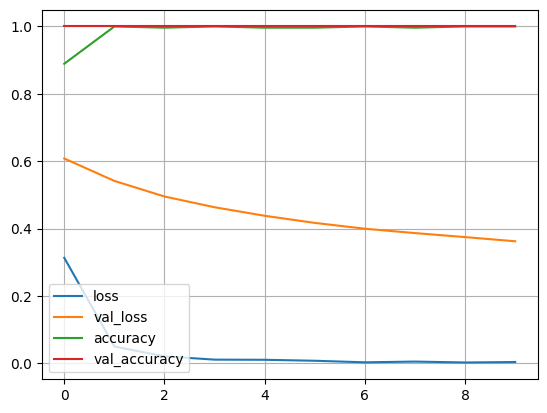

In [45]:
plot_loss(history)

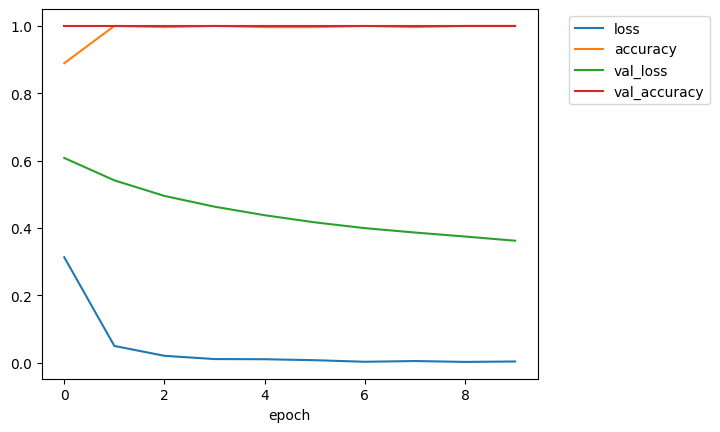

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, clear_output

pd.DataFrame(history.history).plot()
plt.xlabel("epoch")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

In [47]:
loss, acc = MLP.evaluate(X_test, y_test)

2/2 [==============================] - 0s 9ms/step - loss: 0.3813 - accuracy: 1.0000


## Exp2

/usr/local/lib/python3.10/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


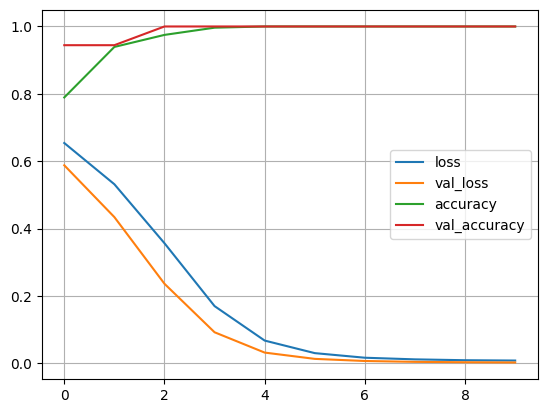

In [48]:
MLP = tf.keras.Sequential([
    tf.keras.layers.Dense(228, activation='relu'),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.33),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

MLP.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

batch_end_loss = list()
batch_end_acc = list()
class SaveBatchLoss(tf.keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None): 
        batch_end_loss.append(logs['loss'])
        batch_end_acc.append(logs['accuracy'])

history = MLP.fit(
    X_train, y_train, epochs=10,
    validation_data = (X_val, y_val),
    verbose=0,
    callbacks=SaveBatchLoss(),
)

plot_loss(history)

In [49]:
loss, acc = MLP.evaluate(X_test, y_test)

2/2 [==============================] - 0s 11ms/step - loss: 0.0074 - accuracy: 1.0000


# Exp3

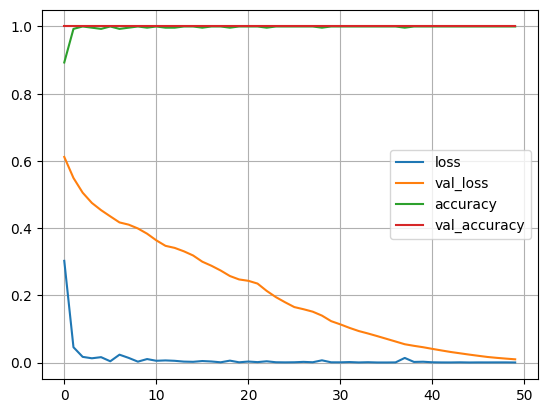

In [51]:
MLP = tf.keras.Sequential([
    tf.keras.layers.Dense(228, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.33),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

MLP.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

batch_end_loss = list()
batch_end_acc = list()
class SaveBatchLoss(tf.keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None): 
        batch_end_loss.append(logs['loss'])
        batch_end_acc.append(logs['accuracy'])

history = MLP.fit(
    X_train, y_train, epochs=50,
    validation_data = (X_val, y_val),
    verbose=0,
    callbacks=SaveBatchLoss(),
)

plot_loss(history)

In [52]:
loss, acc = MLP.evaluate(X_test, y_test)

2/2 [==============================] - 0s 8ms/step - loss: 0.0134 - accuracy: 1.0000


# Exp4

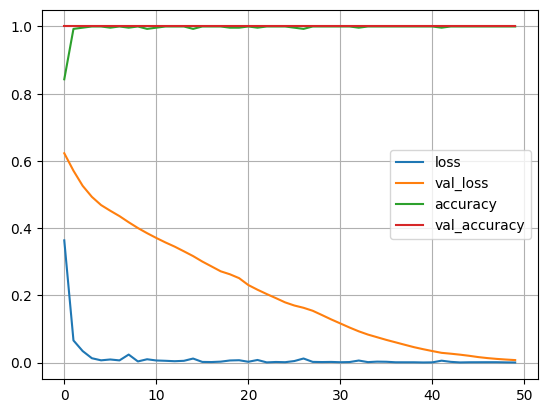

In [53]:
MLP = tf.keras.Sequential([
    tf.keras.layers.Dense(228, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.33),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.33),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

MLP.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

batch_end_loss = list()
batch_end_acc = list()
class SaveBatchLoss(tf.keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None): 
        batch_end_loss.append(logs['loss'])
        batch_end_acc.append(logs['accuracy'])

history = MLP.fit(
    X_train, y_train, epochs=50,
    validation_data = (X_val, y_val),
    verbose=0,
    callbacks=SaveBatchLoss(),
)

plot_loss(history)

In [54]:
loss, acc = MLP.evaluate(X_test, y_test)

2/2 [==============================] - 0s 8ms/step - loss: 0.0107 - accuracy: 1.0000


# Exp 5 ch test_size

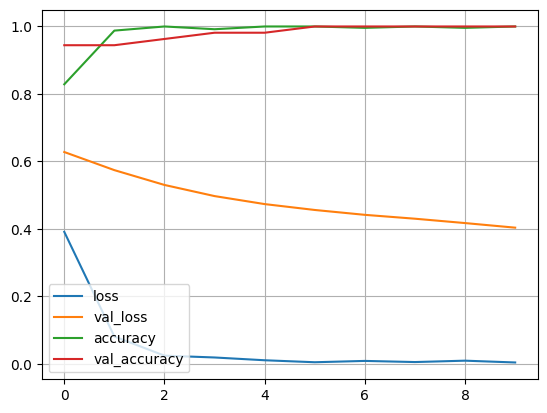

In [55]:
tr_sh = int(0.7 * y.shape[0])
ts_sh = int(0.15 * y.shape[0])
vl_sh = y.shape[0] - tr_sh - ts_sh
Train, Val, Test = tf.split(tf.random.shuffle(Xy), [tr_sh, vl_sh, ts_sh], 0)
X_train, y_train = Train[:,:-1], Train[:,-1]
X_val, y_val = Val[:,:-1], Val[:,-1]
X_test, y_test = Test[:,:-1], Test[:,-1]

MLP = tf.keras.Sequential([
    tf.keras.layers.Dense(228, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.33),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

MLP.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


history = MLP.fit(
    X_train, y_train, epochs=10,
    validation_data = (X_val, y_val),
    verbose=0,
)

plot_loss(history)

In [56]:
loss, acc = MLP.evaluate(X_test, y_test)

2/2 [==============================] - 0s 9ms/step - loss: 0.3939 - accuracy: 1.0000


# Exp 6


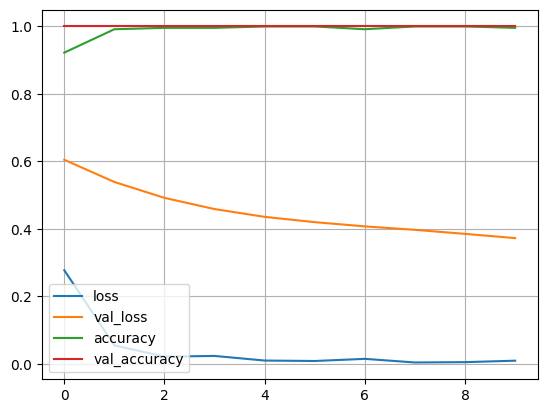

In [57]:
tr_sh = int(0.7 * y.shape[0])
ts_sh = int(0.2 * y.shape[0])
vl_sh = y.shape[0] - tr_sh - ts_sh
Train, Val, Test = tf.split(tf.random.shuffle(Xy), [tr_sh, vl_sh, ts_sh], 0)
X_train, y_train = Train[:,:-1], Train[:,-1]
X_val, y_val = Val[:,:-1], Val[:,-1]
X_test, y_test = Test[:,:-1], Test[:,-1]

MLP = tf.keras.Sequential([
    tf.keras.layers.Dense(228, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.33),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

MLP.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


history = MLP.fit(
    X_train, y_train, epochs=10,
    validation_data = (X_val, y_val),
    verbose=0,
)

plot_loss(history)

In [58]:
loss, acc = MLP.evaluate(X_test, y_test)

3/3 [==============================] - 0s 8ms/step - loss: 0.3795 - accuracy: 1.0000


# Exp 7

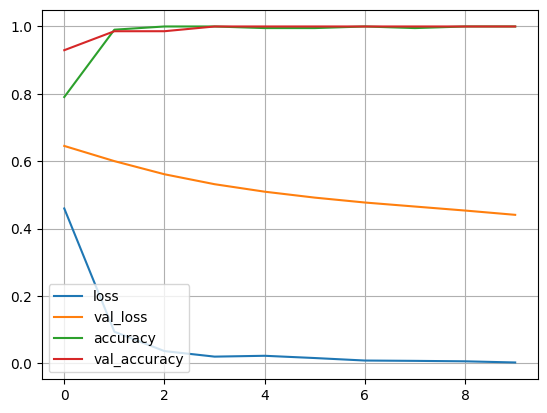

In [59]:
tr_sh = int(0.6 * y.shape[0])
ts_sh = int(0.2 * y.shape[0])
vl_sh = y.shape[0] - tr_sh - ts_sh
Train, Val, Test = tf.split(tf.random.shuffle(Xy), [tr_sh, vl_sh, ts_sh], 0)
X_train, y_train = Train[:,:-1], Train[:,-1]
X_val, y_val = Val[:,:-1], Val[:,-1]
X_test, y_test = Test[:,:-1], Test[:,-1]

MLP = tf.keras.Sequential([
    tf.keras.layers.Dense(228, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.33),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

MLP.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


history = MLP.fit(
    X_train, y_train, epochs=10,
    validation_data = (X_val, y_val),
    verbose=0,
)

plot_loss(history)

In [60]:
loss, acc = MLP.evaluate(X_test, y_test)

3/3 [==============================] - 0s 8ms/step - loss: 0.4260 - accuracy: 1.0000


# Exp 8

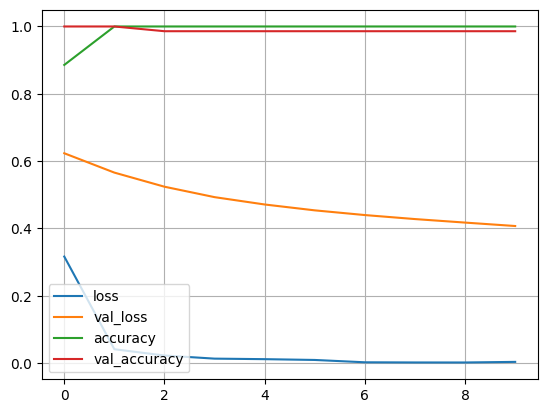

In [61]:
tr_sh = int(0.6 * y.shape[0])
ts_sh = int(0.2 * y.shape[0])
vl_sh = y.shape[0] - tr_sh - ts_sh
Train, Val, Test = tf.split(tf.random.shuffle(Xy), [tr_sh, vl_sh, ts_sh], 0)
X_train, y_train = Train[:,:-1], Train[:,-1]
X_val, y_val = Val[:,:-1], Val[:,-1]
X_test, y_test = Test[:,:-1], Test[:,-1]

MLP = tf.keras.Sequential([
    tf.keras.layers.Dense(228, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.Dropout(0.33),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

MLP.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


history = MLP.fit(
    X_train, y_train, epochs=10,
    validation_data = (X_val, y_val),
    verbose=0,
)

plot_loss(history)

In [62]:
loss, acc = MLP.evaluate(X_test, y_test)

3/3 [==============================] - 0s 6ms/step - loss: 0.3982 - accuracy: 1.0000


# Exp 9

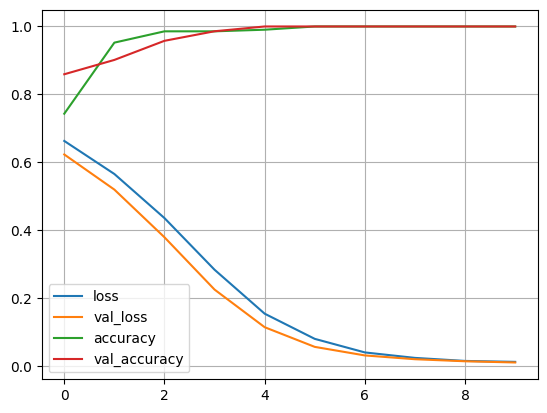

In [64]:
tr_sh = int(0.6 * y.shape[0])
ts_sh = int(0.2 * y.shape[0])
vl_sh = y.shape[0] - tr_sh - ts_sh
Train, Val, Test = tf.split(tf.random.shuffle(Xy), [tr_sh, vl_sh, ts_sh], 0)
X_train, y_train = Train[:,:-1], Train[:,-1]
X_val, y_val = Val[:,:-1], Val[:,-1]
X_test, y_test = Test[:,:-1], Test[:,-1]

MLP = tf.keras.Sequential([
    tf.keras.layers.Dense(228, activation='relu'),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.33),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

MLP.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


history = MLP.fit(
    X_train, y_train, epochs=10,
    validation_data = (X_val, y_val),
    verbose=0,
)

plot_loss(history)

In [65]:
loss, acc = MLP.evaluate(X_test, y_test)

3/3 [==============================] - 0s 6ms/step - loss: 0.0157 - accuracy: 1.0000


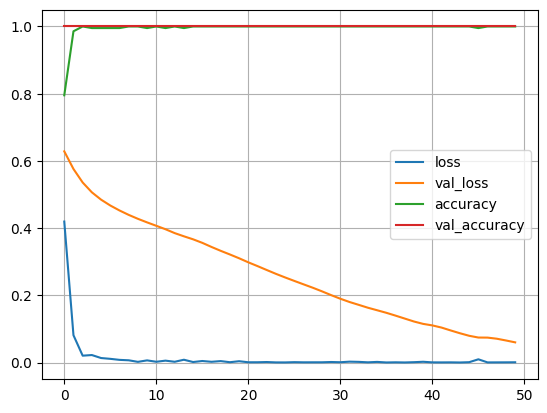

In [76]:
tr_sh = int(0.6 * y.shape[0])
ts_sh = int(0.2 * y.shape[0])
vl_sh = y.shape[0] - tr_sh - ts_sh
Train, Val, Test = tf.split(tf.random.shuffle(Xy), [tr_sh, vl_sh, ts_sh], 0)
X_train, y_train = Train[:,:-1], Train[:,-1]
X_val, y_val = Val[:,:-1], Val[:,-1]
X_test, y_test = Test[:,:-1], Test[:,-1]

MLP = tf.keras.Sequential([
    tf.keras.layers.Dense(228, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

MLP.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


history = MLP.fit(
    X_train, y_train, epochs=50,
    validation_data = (X_val, y_val),
    verbose=0,
)

plot_loss(history)

In [77]:
loss, acc = MLP.evaluate(X_test, y_test)

3/3 [==============================] - 0s 5ms/step - loss: 0.0565 - accuracy: 1.0000


# Exp 10 layer size

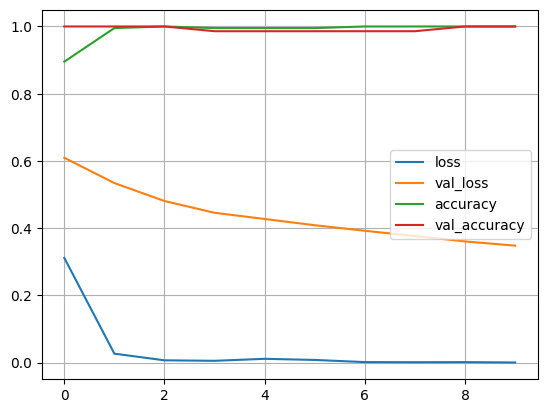

In [17]:
tr_sh = int(0.6 * y.shape[0])
ts_sh = int(0.2 * y.shape[0])
vl_sh = y.shape[0] - tr_sh - ts_sh
Train, Val, Test = tf.split(tf.random.shuffle(Xy), [tr_sh, vl_sh, ts_sh], 0)
X_train, y_train = Train[:,:-1], Train[:,-1]
X_val, y_val = Val[:,:-1], Val[:,-1]
X_test, y_test = Test[:,:-1], Test[:,-1]

MLP = tf.keras.Sequential([
    tf.keras.layers.Dense(228, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.33),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

MLP.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


history = MLP.fit(
    X_train, y_train, epochs=10,
    validation_data = (X_val, y_val),
    verbose=0,
)

plot_loss(history)

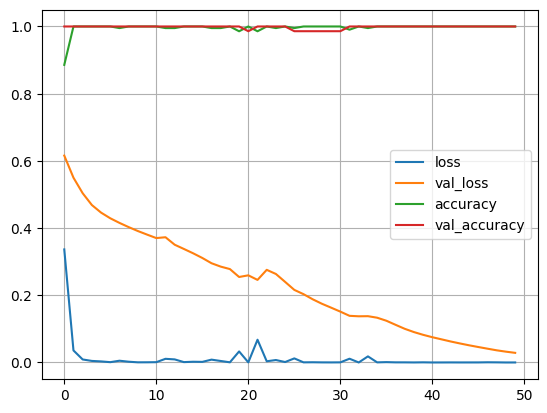

In [19]:
MLP = tf.keras.Sequential([
    tf.keras.layers.Dense(228, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.33),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

MLP.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


history = MLP.fit(
    X_train, y_train, epochs=50,
    validation_data = (X_val, y_val),
    verbose=0,
)

plot_loss(history)

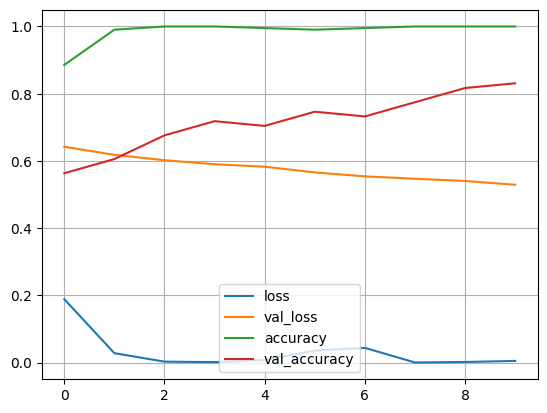

In [20]:
tr_sh = int(0.6 * y.shape[0])
ts_sh = int(0.2 * y.shape[0])
vl_sh = y.shape[0] - tr_sh - ts_sh
Train, Val, Test = tf.split(tf.random.shuffle(Xy), [tr_sh, vl_sh, ts_sh], 0)
X_train, y_train = Train[:,:-1], Train[:,-1]
X_val, y_val = Val[:,:-1], Val[:,-1]
X_test, y_test = Test[:,:-1], Test[:,-1]

MLP = tf.keras.Sequential([
    tf.keras.layers.Dense(228, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.33),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

MLP.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


history = MLP.fit(
    X_train, y_train, epochs=10,
    validation_data = (X_val, y_val),
    verbose=0,
)

plot_loss(history)

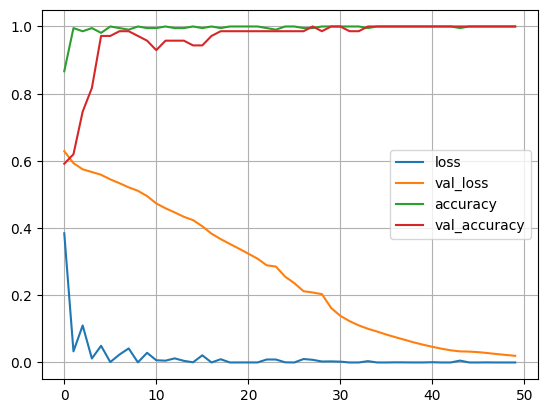

In [26]:
tr_sh = int(0.6 * y.shape[0])
ts_sh = int(0.2 * y.shape[0])
vl_sh = y.shape[0] - tr_sh - ts_sh
Train, Val, Test = tf.split(tf.random.shuffle(Xy), [tr_sh, vl_sh, ts_sh], 0)
X_train, y_train = Train[:,:-1], Train[:,-1]
X_val, y_val = Val[:,:-1], Val[:,-1]
X_test, y_test = Test[:,:-1], Test[:,-1]

MLP = tf.keras.Sequential([
    tf.keras.layers.Dense(228, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.33),
    tf.keras.layers.Dense(2000, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

MLP.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


history = MLP.fit(
    X_train, y_train, epochs=50,
    validation_data = (X_val, y_val),
    verbose=0,
)

plot_loss(history)

In [27]:
loss, acc = MLP.evaluate(X_test, y_test)

3/3 [==============================] - 0s 5ms/step - loss: 0.0110 - accuracy: 1.0000


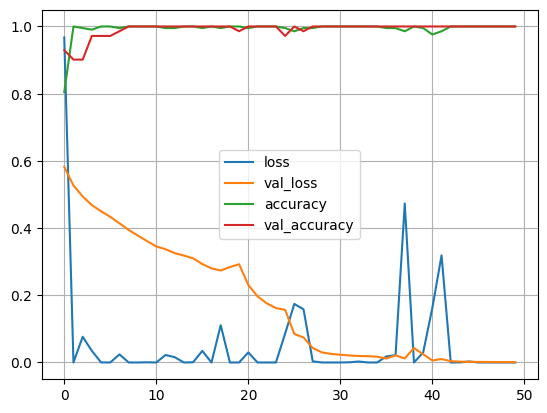

In [24]:
tr_sh = int(0.6 * y.shape[0])
ts_sh = int(0.2 * y.shape[0])
vl_sh = y.shape[0] - tr_sh - ts_sh
Train, Val, Test = tf.split(tf.random.shuffle(Xy), [tr_sh, vl_sh, ts_sh], 0)
X_train, y_train = Train[:,:-1], Train[:,-1]
X_val, y_val = Val[:,:-1], Val[:,-1]
X_test, y_test = Test[:,:-1], Test[:,-1]

MLP = tf.keras.Sequential([
    tf.keras.layers.Dense(228, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.33),
    tf.keras.layers.Dense(10000, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

MLP.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


history = MLP.fit(
    X_train, y_train, epochs=50,
    validation_data = (X_val, y_val),
    verbose=0,
)

plot_loss(history)

In [25]:
loss, acc = MLP.evaluate(X_test, y_test)

3/3 [==============================] - 0s 17ms/step - loss: 0.0124 - accuracy: 0.9857


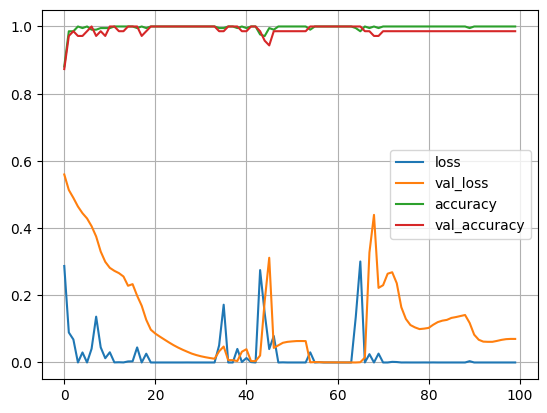

In [30]:
tr_sh = int(0.6 * y.shape[0])
ts_sh = int(0.2 * y.shape[0])
vl_sh = y.shape[0] - tr_sh - ts_sh
Train, Val, Test = tf.split(tf.random.shuffle(Xy), [tr_sh, vl_sh, ts_sh], 0)
X_train, y_train = Train[:,:-1], Train[:,-1]
X_val, y_val = Val[:,:-1], Val[:,-1]
X_test, y_test = Test[:,:-1], Test[:,-1]

MLP = tf.keras.Sequential([
    tf.keras.layers.Dense(228, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.33),
    tf.keras.layers.Dense(10000, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

MLP.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


history = MLP.fit(
    X_train, y_train, epochs=100,
    validation_data = (X_val, y_val),
    verbose=0,
)

plot_loss(history)

In [31]:
loss, acc = MLP.evaluate(X_test, y_test)

3/3 [==============================] - 0s 10ms/step - loss: 8.1672e-16 - accuracy: 1.0000


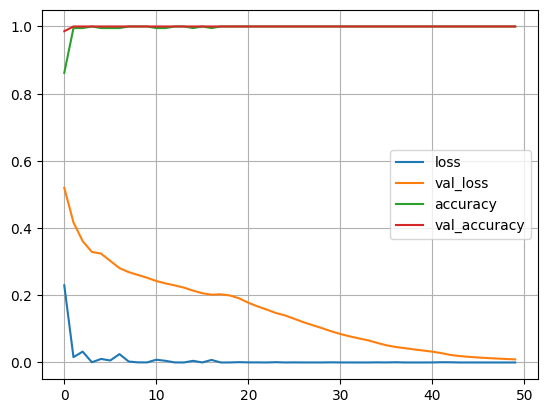

In [28]:
tr_sh = int(0.6 * y.shape[0])
ts_sh = int(0.2 * y.shape[0])
vl_sh = y.shape[0] - tr_sh - ts_sh
Train, Val, Test = tf.split(tf.random.shuffle(Xy), [tr_sh, vl_sh, ts_sh], 0)
X_train, y_train = Train[:,:-1], Train[:,-1]
X_val, y_val = Val[:,:-1], Val[:,-1]
X_test, y_test = Test[:,:-1], Test[:,-1]

MLP = tf.keras.Sequential([
    tf.keras.layers.Dense(228, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.33),
    tf.keras.layers.Dense(10000, activation='relu'),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

MLP.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


history = MLP.fit(
    X_train, y_train, epochs=50,
    validation_data = (X_val, y_val),
    verbose=0,
)

plot_loss(history)

In [29]:
loss, acc = MLP.evaluate(X_test, y_test)

3/3 [==============================] - 0s 12ms/step - loss: 0.0077 - accuracy: 1.0000


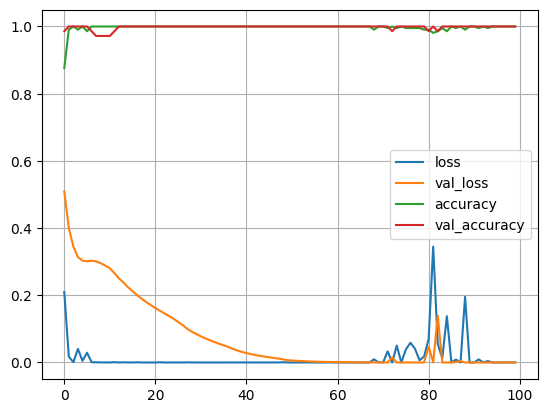

In [32]:
tr_sh = int(0.6 * y.shape[0])
ts_sh = int(0.2 * y.shape[0])
vl_sh = y.shape[0] - tr_sh - ts_sh
Train, Val, Test = tf.split(tf.random.shuffle(Xy), [tr_sh, vl_sh, ts_sh], 0)
X_train, y_train = Train[:,:-1], Train[:,-1]
X_val, y_val = Val[:,:-1], Val[:,-1]
X_test, y_test = Test[:,:-1], Test[:,-1]

MLP = tf.keras.Sequential([
    tf.keras.layers.Dense(228, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.33),
    tf.keras.layers.Dense(10000, activation='relu'),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

MLP.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


history = MLP.fit(
    X_train, y_train, epochs=100,
    validation_data = (X_val, y_val),
    verbose=0,
)

plot_loss(history)

In [33]:
loss, acc = MLP.evaluate(X_test, y_test)

3/3 [==============================] - 0s 8ms/step - loss: 2.3201e-08 - accuracy: 1.0000


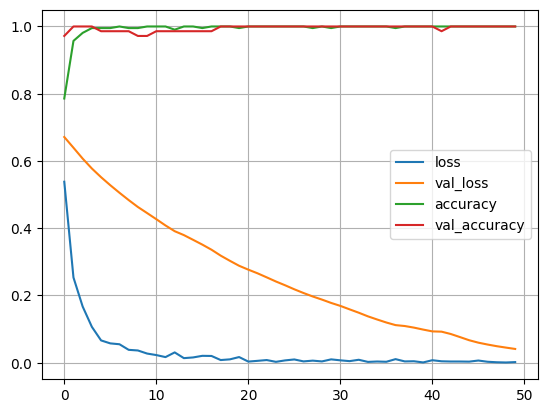

In [36]:
tr_sh = int(0.6 * y.shape[0])
ts_sh = int(0.2 * y.shape[0])
vl_sh = y.shape[0] - tr_sh - ts_sh
Train, Val, Test = tf.split(tf.random.shuffle(Xy), [tr_sh, vl_sh, ts_sh], 0)
X_train, y_train = Train[:,:-1], Train[:,-1]
X_val, y_val = Val[:,:-1], Val[:,-1]
X_test, y_test = Test[:,:-1], Test[:,-1]

MLP = tf.keras.Sequential([
    tf.keras.layers.Dense(228, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.33),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

MLP.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


history = MLP.fit(
    X_train, y_train, epochs=50,
    validation_data = (X_val, y_val),
    verbose=0,
)

plot_loss(history)

In [37]:
loss, acc = MLP.evaluate(X_test, y_test)

3/3 [==============================] - 0s 8ms/step - loss: 0.0294 - accuracy: 1.0000


# Exp 11 add layer

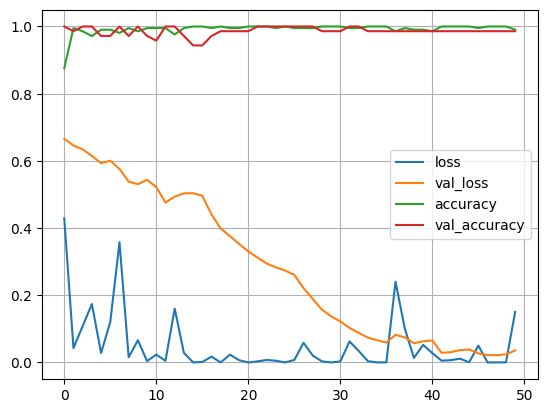

In [38]:
tr_sh = int(0.6 * y.shape[0])
ts_sh = int(0.2 * y.shape[0])
vl_sh = y.shape[0] - tr_sh - ts_sh
Train, Val, Test = tf.split(tf.random.shuffle(Xy), [tr_sh, vl_sh, ts_sh], 0)
X_train, y_train = Train[:,:-1], Train[:,-1]
X_val, y_val = Val[:,:-1], Val[:,-1]
X_test, y_test = Test[:,:-1], Test[:,-1]

MLP = tf.keras.Sequential([
    tf.keras.layers.Dense(228, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.33),
    tf.keras.layers.Dense(10000, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.33),    
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

MLP.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


history = MLP.fit(
    X_train, y_train, epochs=50,
    validation_data = (X_val, y_val),
    verbose=0,
)

plot_loss(history)

In [39]:
loss, acc = MLP.evaluate(X_test, y_test)

3/3 [==============================] - 0s 10ms/step - loss: 0.0302 - accuracy: 0.9857


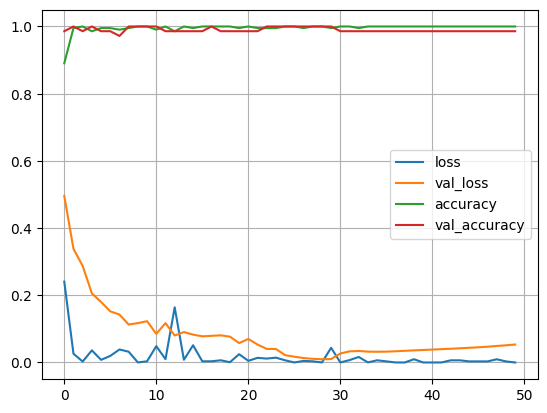

In [40]:
tr_sh = int(0.6 * y.shape[0])
ts_sh = int(0.2 * y.shape[0])
vl_sh = y.shape[0] - tr_sh - ts_sh
Train, Val, Test = tf.split(tf.random.shuffle(Xy), [tr_sh, vl_sh, ts_sh], 0)
X_train, y_train = Train[:,:-1], Train[:,-1]
X_val, y_val = Val[:,:-1], Val[:,-1]
X_test, y_test = Test[:,:-1], Test[:,-1]

MLP = tf.keras.Sequential([
    tf.keras.layers.Dense(228, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.33),
    tf.keras.layers.Dense(10000, activation='relu'),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.33),    
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

MLP.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


history = MLP.fit(
    X_train, y_train, epochs=50,
    validation_data = (X_val, y_val),
    verbose=0,
)

plot_loss(history)

In [41]:
loss, acc = MLP.evaluate(X_test, y_test)

3/3 [==============================] - 0s 11ms/step - loss: 0.0039 - accuracy: 1.0000


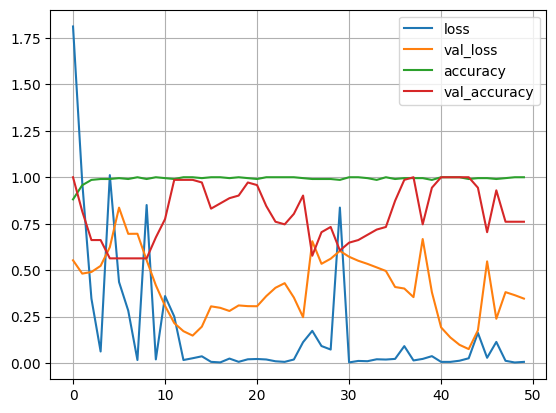

In [44]:
tr_sh = int(0.6 * y.shape[0])
ts_sh = int(0.2 * y.shape[0])
vl_sh = y.shape[0] - tr_sh - ts_sh
Train, Val, Test = tf.split(tf.random.shuffle(Xy), [tr_sh, vl_sh, ts_sh], 0)
X_train, y_train = Train[:,:-1], Train[:,-1]
X_val, y_val = Val[:,:-1], Val[:,-1]
X_test, y_test = Test[:,:-1], Test[:,-1]

MLP = tf.keras.Sequential([
    tf.keras.layers.Dense(228, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.33),
    tf.keras.layers.Dense(100000, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.33),    
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

MLP.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


history = MLP.fit(
    X_train, y_train, epochs=50,
    validation_data = (X_val, y_val),
    verbose=0,
)

plot_loss(history)

In [45]:
loss, acc = MLP.evaluate(X_test, y_test)

3/3 [==============================] - 0s 28ms/step - loss: 0.3226 - accuracy: 0.7571


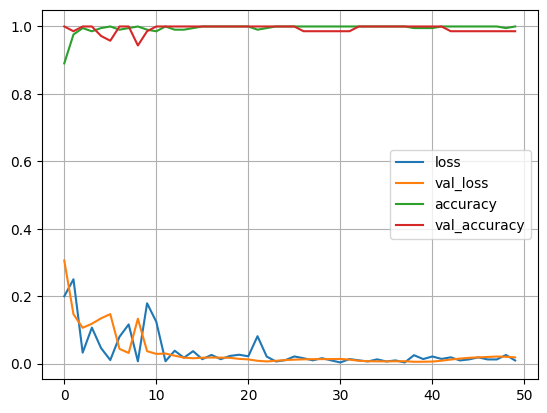

In [46]:
tr_sh = int(0.6 * y.shape[0])
ts_sh = int(0.2 * y.shape[0])
vl_sh = y.shape[0] - tr_sh - ts_sh
Train, Val, Test = tf.split(tf.random.shuffle(Xy), [tr_sh, vl_sh, ts_sh], 0)
X_train, y_train = Train[:,:-1], Train[:,-1]
X_val, y_val = Val[:,:-1], Val[:,-1]
X_test, y_test = Test[:,:-1], Test[:,-1]

MLP = tf.keras.Sequential([
    tf.keras.layers.Dense(228, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.33),
    tf.keras.layers.Dense(100000, activation='relu'),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.33),    
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

MLP.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


history = MLP.fit(
    X_train, y_train, epochs=50,
    validation_data = (X_val, y_val),
    verbose=0,
)

plot_loss(history)

In [47]:
loss, acc = MLP.evaluate(X_test, y_test)

3/3 [==============================] - 0s 25ms/step - loss: 1.5031e-07 - accuracy: 1.0000


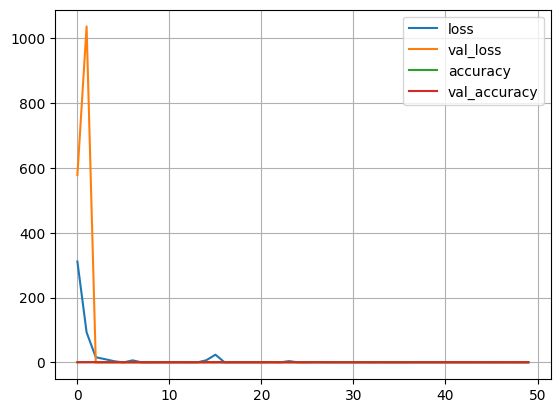

In [48]:
tr_sh = int(0.6 * y.shape[0])
ts_sh = int(0.2 * y.shape[0])
vl_sh = y.shape[0] - tr_sh - ts_sh
Train, Val, Test = tf.split(tf.random.shuffle(Xy), [tr_sh, vl_sh, ts_sh], 0)
X_train, y_train = Train[:,:-1], Train[:,-1]
X_val, y_val = Val[:,:-1], Val[:,-1]
X_test, y_test = Test[:,:-1], Test[:,-1]

MLP = tf.keras.Sequential([
    tf.keras.layers.Dense(228, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.33),
    tf.keras.layers.Dense(100000, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.33),    
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

MLP.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.1),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


history = MLP.fit(
    X_train, y_train, epochs=50,
    validation_data = (X_val, y_val),
    verbose=0,
)

plot_loss(history)

In [49]:
loss, acc = MLP.evaluate(X_test, y_test)

3/3 [==============================] - 0s 32ms/step - loss: 0.2805 - accuracy: 0.9000


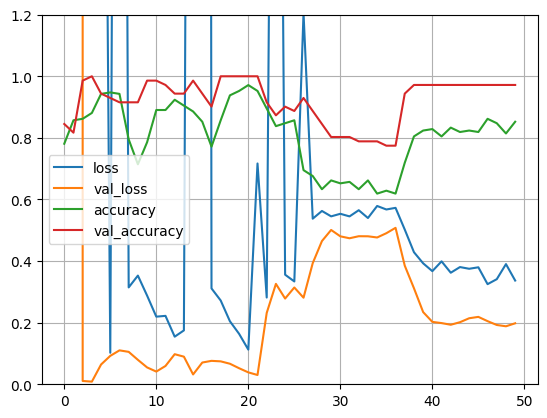

In [51]:
def plot_loss_sc(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label='val_accuracy')  
  plt.ylim([0, 1.2])
  # plt.xlabel('Epoch')
  # plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss_sc(history)

слишком большой лернинг рейт

/usr/local/lib/python3.10/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


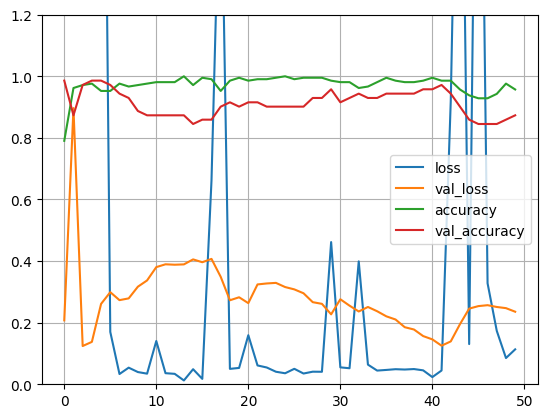

In [52]:
MLP = tf.keras.Sequential([
    tf.keras.layers.Dense(228, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.33),
    tf.keras.layers.Dense(100000, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.33),    
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

MLP.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.01),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


history = MLP.fit(
    X_train, y_train, epochs=50,
    validation_data = (X_val, y_val),
    verbose=0,
)

plot_loss_sc(history)

In [53]:
loss, acc = MLP.evaluate(X_test, y_test)

3/3 [==============================] - 0s 31ms/step - loss: 0.0865 - accuracy: 0.9857


# Exp 12 from_logits=True

In [59]:
def plot_loss_bin(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.plot(history.history['binary_accuracy'], label='binary_accuracy')
  plt.plot(history.history['val_binary_accuracy'], label='val_binary_accuracy')  
  plt.ylim([0, 1.1])
  # plt.xlabel('Epoch')
  # plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

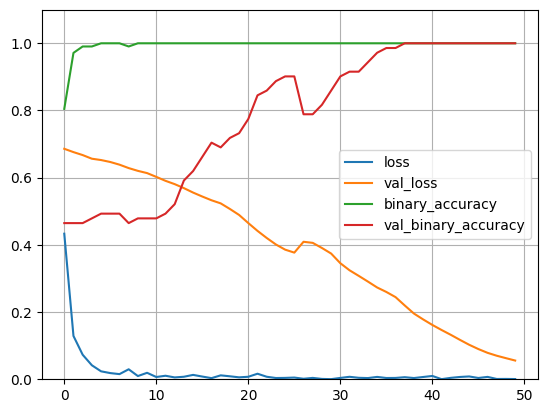

In [68]:
tr_sh = int(0.6 * y.shape[0])
ts_sh = int(0.2 * y.shape[0])
vl_sh = y.shape[0] - tr_sh - ts_sh
Train, Val, Test = tf.split(tf.random.shuffle(Xy), [tr_sh, vl_sh, ts_sh], 0)
X_train, y_train = Train[:,:-1], Train[:,-1]
X_val, y_val = Val[:,:-1], Val[:,-1]
X_test, y_test = Test[:,:-1], Test[:,-1]

MLP = tf.keras.Sequential([
    tf.keras.layers.Dense(228, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.33),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.33),    
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

MLP.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),#from_logits=True),
              metrics=tf.keras.metrics.BinaryAccuracy())


history = MLP.fit(
    X_train, y_train, epochs=50,
    validation_data = (X_val, y_val),
    verbose=0,
)

plot_loss_bin(history)

In [69]:
loss, acc = MLP.evaluate(X_test, y_test)

3/3 [==============================] - 0s 6ms/step - loss: 0.0587 - binary_accuracy: 1.0000


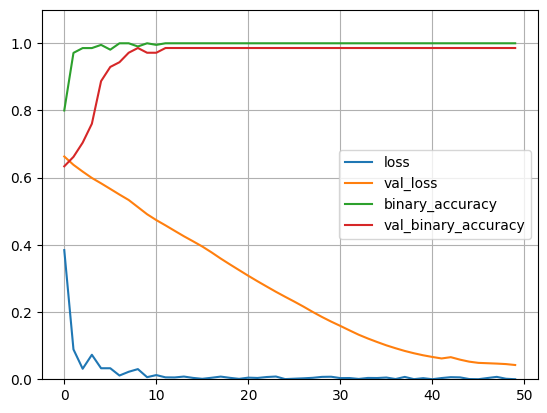

In [70]:
tr_sh = int(0.6 * y.shape[0])
ts_sh = int(0.2 * y.shape[0])
vl_sh = y.shape[0] - tr_sh - ts_sh
Train, Val, Test = tf.split(tf.random.shuffle(Xy), [tr_sh, vl_sh, ts_sh], 0)
X_train, y_train = Train[:,:-1], Train[:,-1]
X_val, y_val = Val[:,:-1], Val[:,-1]
X_test, y_test = Test[:,:-1], Test[:,-1]

MLP = tf.keras.Sequential([
    tf.keras.layers.Dense(228, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.33),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.33),    
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

MLP.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=tf.keras.metrics.BinaryAccuracy())


history = MLP.fit(
    X_train, y_train, epochs=50,
    validation_data = (X_val, y_val),
    verbose=0,
)

plot_loss_bin(history)

In [71]:
loss, acc = MLP.evaluate(X_test, y_test)

3/3 [==============================] - 0s 6ms/step - loss: 0.0093 - binary_accuracy: 1.0000


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


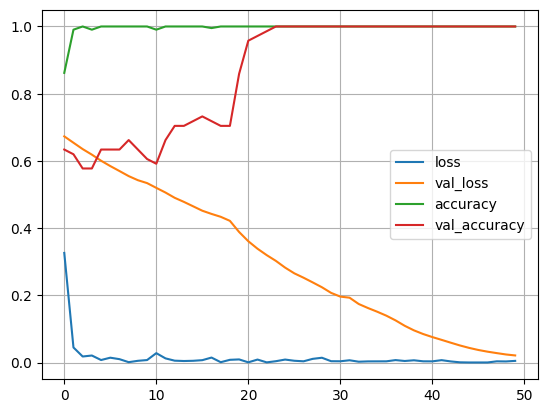

In [72]:
tr_sh = int(0.6 * y.shape[0])
ts_sh = int(0.2 * y.shape[0])
vl_sh = y.shape[0] - tr_sh - ts_sh
Train, Val, Test = tf.split(tf.random.shuffle(Xy), [tr_sh, vl_sh, ts_sh], 0)
X_train, y_train = Train[:,:-1], Train[:,-1]
X_val, y_val = Val[:,:-1], Val[:,-1]
X_test, y_test = Test[:,:-1], Test[:,-1]

MLP = tf.keras.Sequential([
    tf.keras.layers.Dense(228, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.33),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.33),    
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

MLP.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


history = MLP.fit(
    X_train, y_train, epochs=50,
    validation_data = (X_val, y_val),
    verbose=0,
)

plot_loss(history)

In [73]:
tr_sh = int(0.6 * y.shape[0])
ts_sh = int(0.2 * y.shape[0])
vl_sh = y.shape[0] - tr_sh - ts_sh
Train, Val, Test = tf.split(tf.random.shuffle(Xy), [tr_sh, vl_sh, ts_sh], 0)
X_train, y_train = Train[:,:-1], Train[:,-1]
X_val, y_val = Val[:,:-1], Val[:,-1]
X_test, y_test = Test[:,:-1], Test[:,-1]

MLP = tf.keras.Sequential([
    tf.keras.layers.Dense(228, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.33),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.33),    
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

MLP.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       ])


history = MLP.fit(
    X_train, y_train, epochs=50,
    validation_data = (X_val, y_val),
    verbose=0,
)


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


In [75]:
MLP.evaluate(X_test, y_test)

3/3 [==============================] - 0s 12ms/step - loss: 0.0074 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000


[0.0073869177140295506, 1.0, 1.0, 1.0]

In [82]:
def plot_loss_metr(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.plot(history.history['binary_accuracy'], label='accuracy')
  plt.plot(history.history['val_binary_accuracy'], label='val_accuracy')  
  plt.plot(history.history['precision'], label='precision')
  plt.plot(history.history['recall'], label='recall')
  
  # plt.ylim([0, 10])
  # plt.xlabel('Epoch')
  # plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

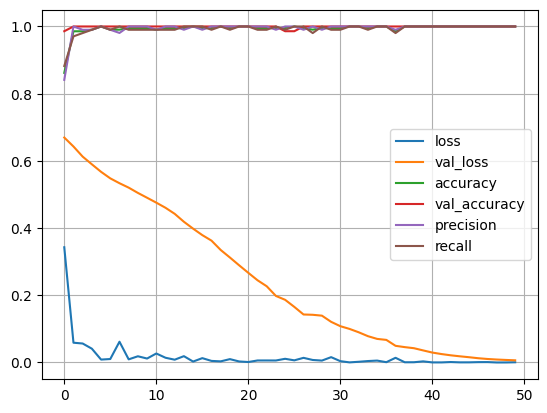

In [79]:
plot_loss_metr(history)

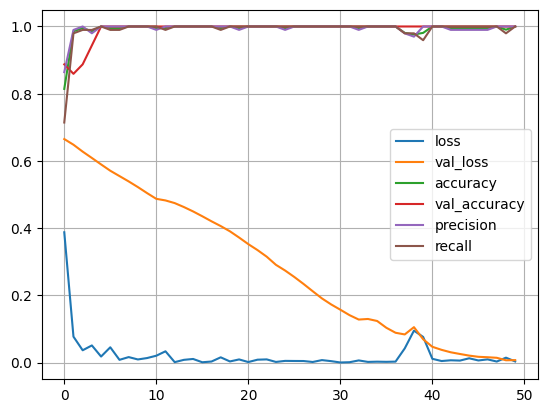

In [89]:
tr_sh = int(0.6 * y.shape[0])
ts_sh = int(0.2 * y.shape[0])
vl_sh = y.shape[0] - tr_sh - ts_sh
Train, Val, Test = tf.split(tf.random.shuffle(Xy), [tr_sh, vl_sh, ts_sh], 0)
X_train, y_train = Train[:,:-1], Train[:,-1]
X_val, y_val = Val[:,:-1], Val[:,-1]
X_test, y_test = Test[:,:-1], Test[:,-1]

MLP = tf.keras.Sequential([
    tf.keras.layers.Dense(228, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.33),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.33),    
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

MLP.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),#from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       ])


history = MLP.fit(
    X_train, y_train, epochs=50,
    validation_data = (X_val, y_val),
    verbose=0,
)
plot_loss_metr(history)

In [90]:
MLP.evaluate(X_test, y_test)

3/3 [==============================] - 0s 7ms/step - loss: 0.0098 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000


[0.009809845127165318, 1.0, 1.0, 1.0]

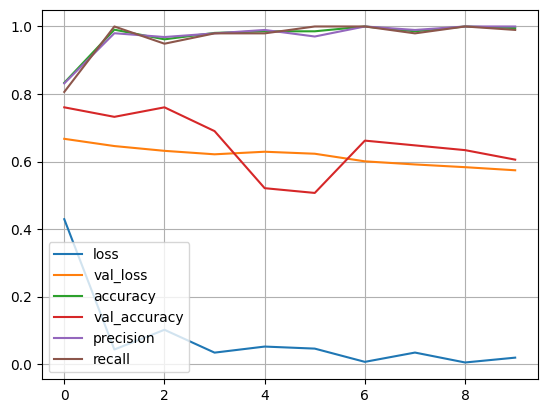

In [95]:
tr_sh = int(0.6 * y.shape[0])
ts_sh = int(0.2 * y.shape[0])
vl_sh = y.shape[0] - tr_sh - ts_sh
Train, Val, Test = tf.split(tf.random.shuffle(Xy), [tr_sh, vl_sh, ts_sh], 0)
X_train, y_train = Train[:,:-1], Train[:,-1]
X_val, y_val = Val[:,:-1], Val[:,-1]
X_test, y_test = Test[:,:-1], Test[:,-1]

MLP = tf.keras.Sequential([
    tf.keras.layers.Dense(228, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.33),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.33),    
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

MLP.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       ])


history = MLP.fit(
    X_train, y_train, epochs=10,
    validation_data = (X_val, y_val),
    verbose=0,
)
plot_loss_metr(history)

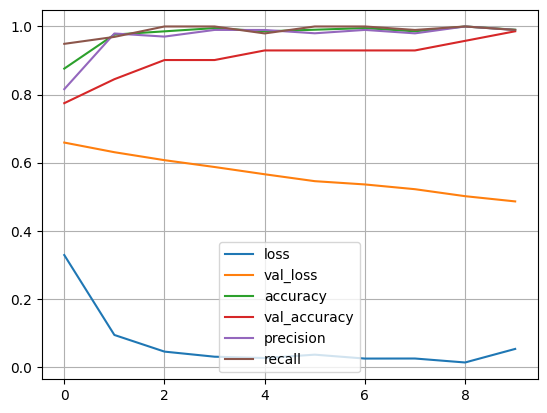

In [96]:
MLP = tf.keras.Sequential([
    tf.keras.layers.Dense(228, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.33),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.33),    
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

MLP.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       ])


history = MLP.fit(
    X_train, y_train, epochs=10,
    validation_data = (X_val, y_val),
    verbose=0,
)
plot_loss_metr(history)

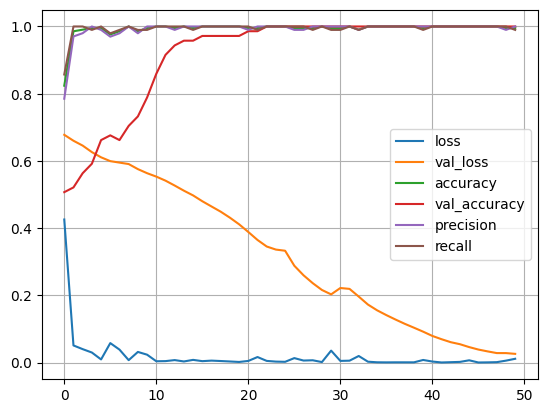

In [97]:
MLP = tf.keras.Sequential([
    tf.keras.layers.Dense(228, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.33),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.33),    
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

MLP.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       ])


history = MLP.fit(
    X_train, y_train, epochs=50,
    validation_data = (X_val, y_val),
    verbose=0,
)
plot_loss_metr(history)

In [98]:
MLP.evaluate(X_test, y_test)

3/3 [==============================] - 0s 12ms/step - loss: 0.0321 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000


[0.03211134672164917, 1.0, 1.0, 1.0]